In [1]:
from Estimate_ABM import *

In [2]:
data_set = {'room air conditioners':(np.arange(1949,1962),[96,195,238,380,1045,1230,1267,1828,1586,1673,1800,1580,1500]),
            'color televisions':(np.arange(1963,1971),[747,1480,2646,5118,5777,5982,5962,4631]),
            'clothers dryers':(np.arange(1949,1962),[106,319,492,635,737,890,1397,1523,1294,1240,1425,1260,1236]),
            'ultrasound':(np.arange(1965,1979),[5,3,2,5,7,12,6,16,16,28,28,21,13,6]),
            'mammography':(np.arange(1965,1979),[2,2,2,3,4,9,7,16,23,24,15,6,5,1]),
            'foreign language':(np.arange(1952,1964),[1.25,0.77,0.86,0.48,1.34,3.56,3.36,6.24,5.95,6.24,4.89,0.25]),
            'accelerated program':(np.arange(1952,1964),[0.67,0.48,2.11,0.29,2.59,2.21,16.80,11.04,14.40,6.43,6.15,1.15])}

china_set = {'color televisions':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
             'mobile phones':(np.arange(1997,2013),[1.7,1.6,3.84,12.36,14.5,28.89,27.18,21.33,25.6,15.88,12.3,6.84,9.02,7.82,16.39,7.39]),
             'computers':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
             'conditioners':(np.arange(1992,2013),[1.19,1.14,2.67,3.09,3.52,4.68,3.71,4.48,6.32,5.0,15.3,10.69,8.01,10.87,7.12,7.29,5.2,6.56,5.23,9.93,4.81]),
             'water heaters':(np.arange(1988,2013),[28.07,8.4,5.86,6.37,3.9,4.08,5.42,4.12,3.45,3.31,3.12,1.64,2.36,1.8,5.48,1.35,1.47,0.52,1.03,3.28,-1.4,1.72,1.26,0.62,1.25])
             }

In [14]:
diff = Diffuse(0.001, 0.05, num_runs=13)

In [15]:
t1 = time.clock()
x = diff.repete_diffuse()
print('Time: %.2f s' % (time.clock() - t1))

Time: 8.09 s


In [16]:
mean_x = np.mean(x, axis=0)

In [18]:
t1 = time.clock()
rgs = Random_Grid_Search(mean_x)
sol = rgs.optima_search()
print('Time: %.2f s' % (time.clock() - t1))

Time: 1.83 s


In [3]:
class Est_ABM(Estimate_ABM):
    def solution_search(self, p0, q0):
        solution_cont = []
        diff_cont = []
        pq_cont = []
        evol_params = []
        best_cont = []

        for p in (p0 - self.intv_p, p0, p0 + self.intv_p):
            for q in (q0 - self.intv_q, q0, q0 + self.intv_q):
                pq_cont.append((p, q))
                solution = self.get_M(p, q)
                solution_cont.append(solution[:4]) # M_sse,p,q,s_M
                diff_cont.append(solution[4]) # x
        
        best_solution = sorted(solution_cont)[:self.num_conds]
        evol_params.append(pq_cont)
        best_cont.append([x[1:3] for x in best_solution])
        
        while True:
            solution_cont2 = []
            diff_cont2 = []
            pq_cont2 = []

            for z in best_solution:
                temp = [(z[1]-self.intv_p,z[2]-self.intv_q),(z[1],z[2]-self.intv_q),(z[1]+self.intv_p,z[2]-self.intv_q),
                        (z[1]-self.intv_p,z[2]),       (z[1],z[2]),       (z[1]+self.intv_p,z[2]),
                        (z[1]-self.intv_p,z[2]+self.intv_q),(z[1],z[2]+self.intv_q),(z[1]+self.intv_p,z[2]+self.intv_q)]
                pq_cont2.extend(temp)
            pq_cont2 = list(set(pq_cont2 + pq_cont))

            for y in pq_cont2:
                if y in pq_cont:
                    solution_cont2.append(solution_cont[pq_cont.index(y)])
                    diff_cont2.append(diff_cont[pq_cont.index(y)])
                else:
                    solution = self.get_M(y[0], y[1])
                    solution_cont2.append(solution[:4])
                    diff_cont2.append(solution[4])

            best_solution = sorted(solution_cont2)[:self.num_conds]
            opt_solution = best_solution[0]
            opt_curve = diff_cont2[solution_cont2.index(opt_solution)]
            
            evol_params.append(pq_cont2)
            best_cont.append([x[1:3] for x in best_solution])

            if len(pq_cont2) == len(pq_cont):
                break
            else:
                solution_cont = solution_cont2
                diff_cont = diff_cont2
                pq_cont = pq_cont2

        f_act = opt_curve
        R2 = self.r2(f_act)
        search_steps = len(pq_cont)
        result = {'params':opt_solution[1:], 'fitness':R2, 'best_curve':f_act, 'steps':search_steps,
                  'path':pq_cont, 'his_path':evol_params,  'his_best':best_cont}  # [p,q,m],拟合曲线,搜索步数,搜索范围
        return result

In [4]:
s = data_set['clothers dryers'][1]

In [5]:
t = time.clock()
est_abm = Est_ABM(s)
t1 = time.clock()
p0, q0 = est_abm.gener_p0_q0()
print('Time for getting the intial guess: %.2f s' % (time.clock() - t1))
result = est_abm.solution_search(p0,q0)
print('Time for all processes: %.2f s' % (time.clock() - t))

Searching ends in 100 runs
Time for getting the intial guess: 110.81 s
Time for all processes: 343.12 s


In [6]:
len(result['his_path'])

4

In [7]:
result['params']

(0.011587624720544504, 0.063291255475673214, 18263.046426893419)

In [8]:
result['steps']

23

In [9]:
result['fitness']

0.9363126239912567

In [13]:
len(result['his_path'][-1])

23

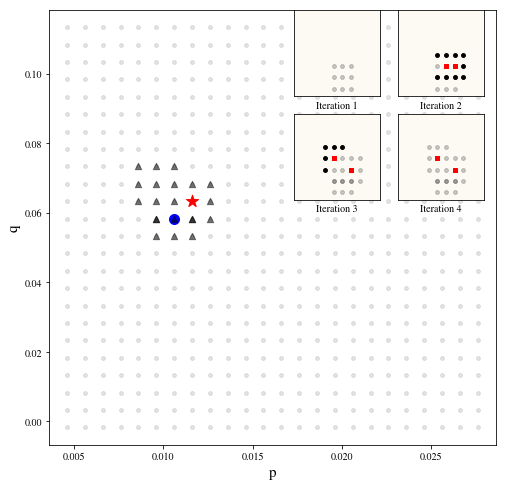

In [10]:
% matplotlib inline
p_range = [round(p0 + i * 0.001, 4) for i in range(-6, 18)]
q_range = [round(q0 + i * 0.005, 4) for i in range(-12, 12)]
x, y = np.meshgrid(p_range, q_range)

best_solution = result['params'][:2]
p_q_cont = result['path']

fig = pl.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('p',fontsize=15)
ax.set_ylabel('q',fontsize=15)
ax.set_xlim([min(p_range) - 0.001, max(p_range) + 0.001])
ax.set_ylim([min(q_range) - 0.005, max(q_range) + 0.005])

for p in p_range:
    for q in q_range:
        ax.scatter(p, q, s=15, c='k', marker='o', alpha = 0.1)

for (p, q) in p_q_cont:
    if (p, q) == best_solution:
        ax.scatter(p, q, s=160, c='r', marker='*')
    elif (p, q) == (p0, q0):
        ax.scatter(p0, q0, s=100, c='b', marker='o')
    else:
        ax.scatter(p, q, s=40, c='k', marker='^', alpha=0.5)

inset_ax1 = fig.add_axes([0.55, 0.73, 0.15, 0.15], facecolor='#FCFAF2')
inset_ax2 = fig.add_axes([0.73, 0.73, 0.15, 0.15], facecolor='#FCFAF2')
inset_ax3 = fig.add_axes([0.55, 0.55, 0.15, 0.15], facecolor='#FCFAF2')
inset_ax4 = fig.add_axes([0.73, 0.55, 0.15, 0.15], facecolor='#FCFAF2')

pq = np.array(result['his_path'][0])
inset_ax1.scatter(pq[:, 0],pq[:, 1], s=15, c='k', marker='o', alpha=0.2)
    
inset_ax1.set_xlim([0.005,0.015])
inset_ax1.set_ylim([0.05,0.088])
inset_ax1.set_xlabel('Iteration 1',fontsize=10)
inset_ax1.set_xticks([])
inset_ax1.set_yticks([])

i = 1
for ax in [inset_ax2,inset_ax3,inset_ax4]:
    pq0 = result['his_path'][i-1]
    pq1 = result['his_path'][i]
    temp = []
    for z in pq1:
        if z in pq0:
            ax.scatter(z[0], z[1], s=15, c='k', marker='o',alpha = 0.2)
        else:
            ax.scatter(z[0], z[1], s=15, c='k',marker='o',alpha = 1)
    solution = result['his_best'][i-1]
    for z in solution:
        ax.scatter(z[0],z[1],s=15,c='r',marker='s',alpha = 1)
            
    ax.set_xlim([0.005, 0.015])
    ax.set_ylim([0.05, 0.088])
    ax.set_xlabel('Iteration %s' % (i+1),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    i = i + 1

In [ ]:
diff =Diffuse(result['params'][0],result['params'][1],len(s))

In [ ]:
r_diff = diff.repete_diffuse()

In [ ]:
result['path']

In [ ]:
pl.plot(result['best_curve']*result['params'][-1]/10000)
pl.plot(s,'ro')

In [ ]:
for x in result['his_path'][1]:
    if x not in result['his_path'][0]:
        print x

In [ ]:
round(0.00001,1)

In [ ]:
temp = []
for t in result['path']:
    temp.append(tuple(map(round,t,[4,4])))
new_path.append(list(set(temp)))

In [ ]:
result['his_path'] = new_path

In [ ]:
result['path'] = temp

In [ ]:
p0,q0

In [ ]:
result['orgi_points'] = []

In [ ]:
import pickle
illust = pickle.dumps(result)
f = open('example of the estimation procedure.txt','w')
f.write(illust)
f.close()